In [51]:
import fluxy as fl
from influxdb_client.client.influxdb_client_async import InfluxDBClientAsync
from dotenv import load_dotenv
import os
from datetime import datetime, timezone, timedelta
import pandas as pd 
import seaborn as sns 
import matplotlib.dates as mdates
import matplotlib.pylab as plt 

load_dotenv()

API_TOKEN = os.getenv("ANALYSIS_API_TOKEN")

In [52]:
from pandas import DataFrame


async def submit_query(fl) -> DataFrame:
  async with InfluxDBClientAsync("https://influxdb.prod.power-hub.foundationzero.org", API_TOKEN, "power_hub") as client:
    
    return await client.query_api().query_data_frame(fl.to_flux())
  
from typing import Any

async def get_data(
    sensors_to_query: list[Any],
    query_range: tuple[datetime, datetime],
    resolution: timedelta,
    windowoperation: fl.WindowOperation,
) -> pd.DataFrame:

    query = fl.pipe(
        fl.from_bucket("power_hub"),
        fl.range(*query_range),
        fl.filter(fl.any(fl.conform, sensors_to_query)),
        fl.aggregate_window(resolution, windowoperation, False),
        fl.keep(["_time", "_value", "_field"]),
        fl.pivot(["_time"], ["_field"], "_value"),
    )
    
    df = await submit_query(query)

    return df.drop(columns = ["result","table"]).set_index("_time",drop = True).sort_index()

In [100]:
from itertools import product

grid_power = [f"electrical_vebus_e{phase}_input_power" for phase in range(1,4)]
AC_power = [f"electrical_vebus_e{phase}_output_power" for phase in range(1,4)]
compound_power = [f'electrical_e{container}_power_{phase}' for container,phase in product(range(1,9),["L1","L2","L3"])]
hub_power = [f'electrical_thermo_cabinet_power_{phase}' for phase in ["L1","L2","L3"]]

electric_variables = [
    #"electrical_pv_power",
    "electrical_grid_power",
    "electrical_total_AC_power",
    "electrical_compound_power_consumption",
    "electrical_thermal_cabinet_power",
    "electrical_office_power",
    "electrical_workshop_power",
    "electrical_simulator_power",
    "electrical_kitchen_sanitary_1_power",
    "electrical_kitchen_sanitary_2_power",
    "electrical_supply_box_power",
    "electrical_center_1_power",
    "electrical_center_2_power",
    "electrical_thermal_cabinet_power",
    "electrical_power_hub_ex_thermal_cabinet_power"
]

In [140]:
start = datetime.now(timezone.utc) - timedelta(days=6)
stop = datetime.now(timezone.utc) - timedelta(days=3)
window_size = timedelta(seconds=10)

In [141]:
electric_data = await get_data([{"_field": variable} for variable in electric_variables], (start, stop), window_size, fl.WindowOperation.LAST)
electric_data.index = electric_data.index.tz_convert('Europe/Madrid')

consumption = electric_data.T.groupby({"electrical_total_AC_power":"victron","electrical_thermal_cabinet_power":"measured", "electrical_compound_power_consumption":"measured"}).sum().T

#kwh_electric = (electric_data / 1000).resample('h').mean()

<Axes: xlabel='_time'>

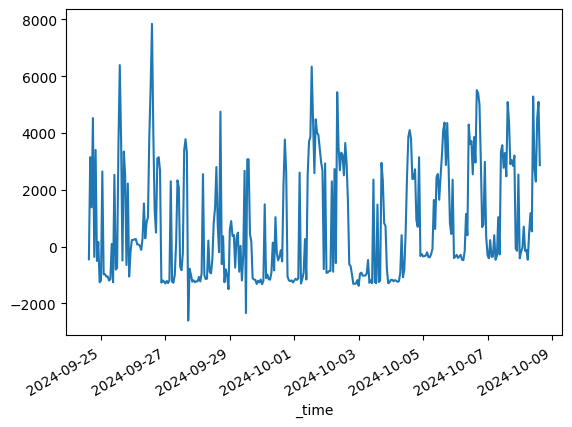

In [131]:
(electric_data['electrical_total_AC_power'] - electric_data['electrical_compound_power_consumption'] - electric_data['electrical_thermal_cabinet_power'] - electric_data['electrical_supply_box_power']).plot()

<Axes: xlabel='_time'>

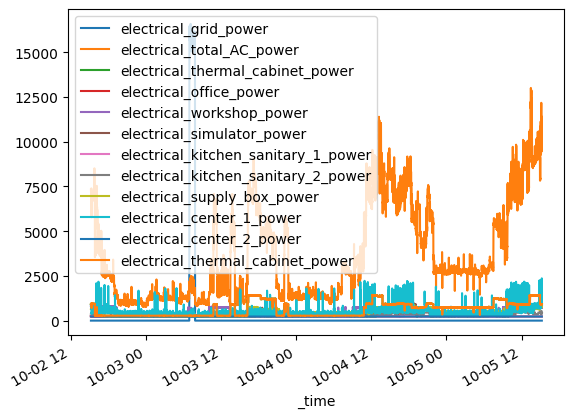

In [142]:
electric_data[["electrical_grid_power",
    "electrical_total_AC_power",
    #"electrical_compound_power_consumption",
    "electrical_thermal_cabinet_power",
    "electrical_office_power",
    "electrical_workshop_power",
    "electrical_simulator_power",
    "electrical_kitchen_sanitary_1_power",
    "electrical_kitchen_sanitary_2_power",
    "electrical_supply_box_power",
    "electrical_center_1_power",
    "electrical_center_2_power",
    "electrical_thermal_cabinet_power"]].plot()

<Axes: xlabel='_time'>

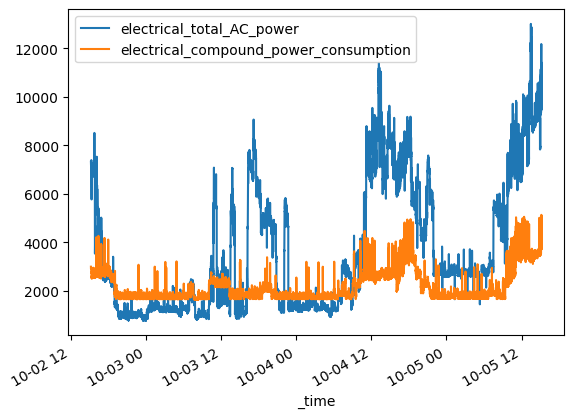

In [143]:
electric_data[[
    "electrical_total_AC_power",
    "electrical_compound_power_consumption"]].plot()

<Axes: xlabel='_time'>

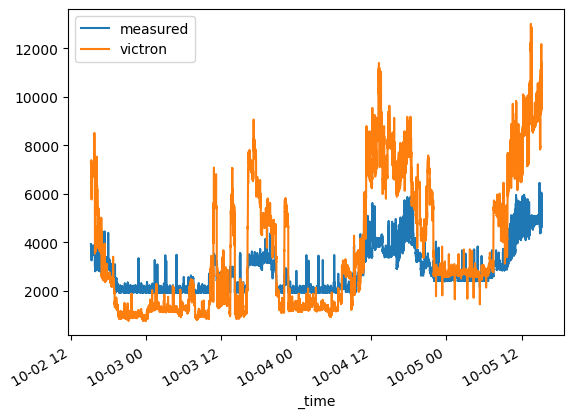

In [144]:
consumption.plot()

<Axes: xlabel='_time'>

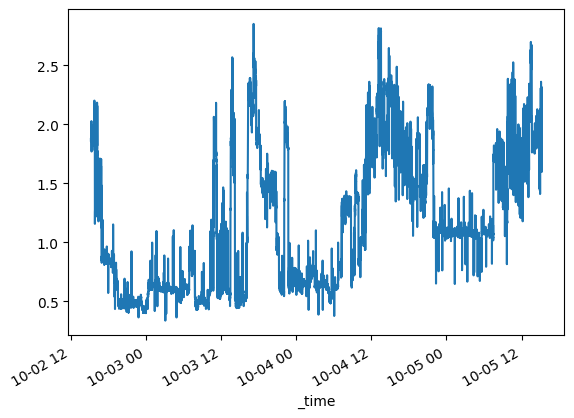

In [145]:
(consumption['victron'] / consumption['measured']).plot()

In [139]:
electric_data.min()

electrical_center_1_power                         229.379898
electrical_center_2_power                           0.000000
electrical_compound_power_consumption            1240.068435
electrical_grid_power                               0.000000
electrical_kitchen_sanitary_1_power               222.600250
electrical_kitchen_sanitary_2_power               222.117111
electrical_office_power                             0.000000
electrical_power_hub_ex_thermal_cabinet_power   -2605.388807
electrical_simulator_power                        233.573181
electrical_supply_box_power                       224.991364
electrical_thermal_cabinet_power                    0.000000
electrical_total_AC_power                           0.000000
electrical_workshop_power                           0.000000
dtype: float64